<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*

**Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1 using topic modeling:** 

- Load in the Amazon Review dataset
- Clean the dataset 
- Vectorize the dataset 
- Fit a Gensim LDA topic model on Amazon Reviews
- Select the appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end
- **Note**: You don't *have* to use generators for this assignment

In [1]:
!python -m spacy download en_core_web_md

     |████████████████████████████████| 96.4 MB 1.1 MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-py3-none-any.whl size=98051302 sha256=4d755081200b983124dffa2dae5866f88dbca65cbd165519026e09f1c26ead40
  Stored in directory: /tmp/pip-ephem-wheel-cache-z4q5wfmf/wheels/69/c5/b8/4f1c029d89238734311b3269762ab2ee325a42da2ce8edb997
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [2]:
!wget https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/main/requirements.txt
!pip install -r requirements.txt

--2021-09-30 18:34:13--  https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/main/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149 [text/plain]
Saving to: ‘requirements.txt’

requirements.txt    100%[===================>]     149  --.-KB/s    in 0s      

2021-09-30 18:34:13 (6.35 MB/s) - ‘requirements.txt’ saved [149/149]

     |████████████████████████████████| 24.2 MB 1.5 MB/s 
     |████████████████████████████████| 1.6 MB 38.2 MB/s 
     |████████████████████████████████| 10.4 MB 33.3 MB/s 
     |████████████████████████████████| 7.1 MB 19.8 MB/s 
     |████████████████████████████████| 208 kB 64.4 MB/s 
     |████████████████████████████████| 2.2 MB 32.3 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-p

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

import spacy

import pyLDAvis
import pyLDAvis.gensim

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from pandarallel import pandarallel

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline 

----
### Load the Amazon Review Corpus 
This dataset is located in the Sprint 1 Module 1 directory. 

If the provided relative path doesn't work for you, then you'll have to provide the file path so pandas can read in the file.

In [5]:
# clone the Unit-4-Sprint-1 repo
!git clone https://github.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP.git
# Find the path to the reviews data zip file, using the file icon on the left sidebar
!unzip /content/DS-Unit-4-Sprint-1-NLP/module1-text-data/data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv.zip

Cloning into 'DS-Unit-4-Sprint-1-NLP'...
remote: Enumerating objects: 1604, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 1604 (delta 32), reused 26 (delta 7), pack-reused 1531
Receiving objects: 100% (1604/1604), 58.12 MiB | 21.71 MiB/s, done.
Resolving deltas: 100% (201/201), done.
Archive:  /content/DS-Unit-4-Sprint-1-NLP/module1-text-data/data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv.zip
  inflating: Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv  
   creating: __MACOSX/
  inflating: __MACOSX/._Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv  


In [6]:
df = pd.read_csv('Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv')

In [7]:
df.head(2)

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,manufacturer,manufacturerNumber,reviews.date,reviews.dateSeen,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2017-03-02T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2016-08-31T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht..."


----

### Clean Data

- Create a function called `clean_data` that uses regex expressions to clean your data in preparation for the vectorizer. 

- Save the clean text data to a column in your dataframe named `clean_text`

- Feel free to re-use old code that you have written in previous modules  

In [8]:
# YOUR CODE HERE
def clean_data(text):
  text = re.sub('[^A-Z a-z]', '', text)
  return text.lower().strip()

In [10]:
# save to cleaned review articles to a feature named `clean_text`
# YOUR CODE HERE
df['clean_text'] = df['reviews.text'].apply(clean_data)
df.head()

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,manufacturer,manufacturerNumber,reviews.date,reviews.dateSeen,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs,clean_text
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2017-03-02T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht...",i order of them and one of the item is bad qu...
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2016-08-31T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht...",bulk is always the less expensive way to go fo...
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2016-12-06T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht...",well they are not duracell but for the price i...
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2016-03-28T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht...",seem to work as well as name brand batteries a...
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",AmazonBasics,HL-002619,2017-04-22T00:00:00.000Z,2017-08-28T00:00:00Z,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht...",these batteries are very long lasting the pric...


In [11]:
alphebetical_chars = ["ABCDEFGHIJKLMNOP"]
# check if any of these alphabetical chars exist in your clean chars
assert df.clean_text.isin(alphebetical_chars).sum() == 0, "Did you case normalize your text inside of your clean_data function?"

------

## Determine Number of Topics

We will run an experiment to determine how many topics exist within the `primaryCategories` of `Electronics`. This is the largest primary category containing nearly 14K documents, so we should have plenty of data. 

Just as we did in the guided project, we'll be running a gridsearch over the number of topics and scoring each model using the Coherence metric to determine which number of topics we should use. 


In [12]:
# create a mask for docs that are in the Electronics primaryCategories - save result to `electronics_mask`
electronics_mask = df.primaryCategories.isin(["Electronics"])

# use mask to isolate all the documents in the Electronics primaryCategories - save result to `df_electronics`
df_electronics = df[electronics_mask]

In [13]:
df_electronics.head(3)

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,manufacturer,manufacturerNumber,reviews.date,reviews.dateSeen,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs,clean_text
8343,AVpe7nGV1cnluZ0-aG2o,2014-10-28T11:14:38Z,2019-04-25T09:05:28Z,AmazonBasics Nylon CD/DVD Binder (400 Capacity),"B00DIHVMEA,B00EZ1ZTV0",Amazonbasics,"Audio & Video Accessories,TV, Video & Home Aud...",Electronics,http://ecx.images-amazon.com/images/I/41jQha7Z...,amazonbasicsnyloncddvdbinder400capacity/b00ez1...,AmazonBasics,YBB12400R2,2017-11-12T00:00:00.000Z,2019-03-25T00:00:00Z,NaN,NaN,NaN,NaN,5,https://www.ebay.com/itm/Amazonbasics-Nylon-Cd...,Great case to keep everything in its place! My...,Excellent product,qs341_5,https://www.ebay.com/itm/AmazonBasics-Nylon-CD...,great case to keep everything in its place my ...
8344,AVpe7nGV1cnluZ0-aG2o,2014-10-28T11:14:38Z,2019-04-25T09:05:28Z,AmazonBasics Nylon CD/DVD Binder (400 Capacity),"B00DIHVMEA,B00EZ1ZTV0",Amazonbasics,"Audio & Video Accessories,TV, Video & Home Aud...",Electronics,http://ecx.images-amazon.com/images/I/41jQha7Z...,amazonbasicsnyloncddvdbinder400capacity/b00ez1...,AmazonBasics,YBB12400R2,2014-06-14T05:00:00Z,2014-08-28T00:00:00Z,NaN,NaN,NaN,NaN,5,http://www.amazon.co.uk/gp/product-reviews/B00...,After discarding and getting rid of broken cd ...,It was a much needed storage,Diablita,https://www.ebay.com/itm/AmazonBasics-Nylon-CD...,after discarding and getting rid of broken cd ...
8345,AVpe7nGV1cnluZ0-aG2o,2014-10-28T11:14:38Z,2019-04-25T09:05:28Z,AmazonBasics Nylon CD/DVD Binder (400 Capacity),"B00DIHVMEA,B00EZ1ZTV0",Amazonbasics,"Audio & Video Accessories,TV, Video & Home Aud...",Electronics,http://ecx.images-amazon.com/images/I/41jQha7Z...,amazonbasicsnyloncddvdbinder400capacity/b00ez1...,AmazonBasics,YBB12400R2,2019-02-15T00:00:00.000Z,2019-03-25T00:00:00Z,NaN,NaN,NaN,NaN,5,https://www.ebay.com/itm/Amazonbasics-Nylon-Cd...,"A few dollars more, but I am boycotting amazon",it was worth it,coldbloodblazing,https://www.ebay.com/itm/AmazonBasics-Nylon-CD...,a few dollars more but i am boycotting amazon


------
### Tokenize your documents 

Remember that you'll need to use the [**corpora**](https://radimrehurek.com/gensim/corpora/dictionary.html) class from the Gensim library. So definitely check out the docs to learn more about this tool. There is an example of how to do this in the guided project.

But before we can use the [**corpora**](https://radimrehurek.com/gensim/corpora/dictionary.html) class, we must first tokenize our articles. 



In [18]:
import os
from pandarallel.utils import progress_bars

In [17]:
os.cpu_count()

2

In [22]:
# identify how many processors your machine has - save the result to `n_processors`
n_processors = 3
# subtract 1 from n_processors - save the result to `nb_workers`
nb_workers = n_processors - 1
# initialize just like we did in the guided project
# COLAB only has 2 processors, set nb_workers=2 and hope that it doesn't crash your notebook (otherwise, don't use this tool)
pandarallel.initialize(progress_bar=True, nb_workers=nb_workers)

# YOUR CODE HERE
progress_bars.is_notebook_lab = lambda : True

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [21]:
# load in the spaCy language model
nlp = spacy.load("en_core_web_md")

In [23]:
%%time
# create our tokens in the form of lemmas 
df_electronics['lemmas'] = df_electronics['clean_text'].parallel_apply(lambda x: [token.lemma_ for token in nlp(x) if (token.is_stop != True) and (token.is_punct != True)])

CPU times: user 4.63 s, sys: 525 ms, total: 5.16 s
Wall time: 2min 20s


In [24]:
df_electronics['lemmas']

8343     [great, case, place, husband, love, hold, lot,...
8344     [discard, get, rid, broken, cd, case, break, c...
8345                             [dollar, boycott, amazon]
8346     [initial, impression, good, material, nice, sh...
8347     [pro, standard, echo, con, old, generation, ec...
                               ...                        
28327    [get,  ,  , yr, old, twin,  , yr, old, better,...
28328    [buy, niece, christmas, giftshe,  , year, old,...
28329    [nice, light, internet, browsing, keep, email,...
28330    [tablet, absolutely, want, watch, tv, show, mo...
28331    [ninety, dollar, expectionations, low, good, t...
Name: lemmas, Length: 13995, dtype: object

In [25]:
def lemFilter(lemmas):
  return [lemma for lemma in lemmas if len(lemma) > 2]

In [27]:
df_electronics['filtered_lemmas'] = df_electronics['lemmas'].parallel_apply(lemFilter)

In [30]:
df_electronics['filtered_lemmas']

8343        [great, case, place, husband, love, hold, lot]
8344     [discard, get, rid, broken, case, break, selec...
8345                             [dollar, boycott, amazon]
8346     [initial, impression, good, material, nice, sh...
8347     [pro, standard, echo, con, old, generation, ec...
                               ...                        
28327    [get, old, twin, old, better, perfect, way, read]
28328    [buy, niece, christmas, giftshe, year, old, love]
28329    [nice, light, internet, browsing, keep, email,...
28330    [tablet, absolutely, want, watch, show, movie,...
28331    [ninety, dollar, expectionations, low, good, t...
Name: filtered_lemmas, Length: 13995, dtype: object

### Use the Corpora Class to Prep Your Data for LDA

You'll need to create the same `id2word` and `corpus` objects that we created in the guided projects. So be sure to reference the guided project notebook if you need to. 

In [31]:
# Create lemma dictionary using Dictionary - save the result to `id2word`
id2word = corpora.Dictionary(df_electronics['filtered_lemmas'])
# Create Term Document Frequency list - save the result to `corpus`
corpus = [id2word.doc2bow(text) for text in df_electronics['filtered_lemmas']]
# YOUR CODE HERE

## Gridsearch the Number of Topics 

Just as we did in the guided project, we're going to run a loop over a range of a possible number of topics and then plot the coherence values to determine which number of topics leads to the most sensible grouping of documents. 

In [32]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary: Gensim dictionary
    corpus: Gensim corpus
    texts: List of input texts
    limit: Max num of topics

    Returns:
    -------
    model_list: List of LDA topic models
    coherence_values: Coherence values corresponding to the LDA model with the respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=num_topics, 
                                                        chunksize=100,
                                                        passes=10,
                                                        random_state=1234,
                                                        per_word_topics=True,
                                                        workers=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [33]:
%%time
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=df_electronics['lemmas'], start=2, limit=22, step=2)

CPU times: user 4min 44s, sys: 35.8 s, total: 5min 20s
Wall time: 10min 51s


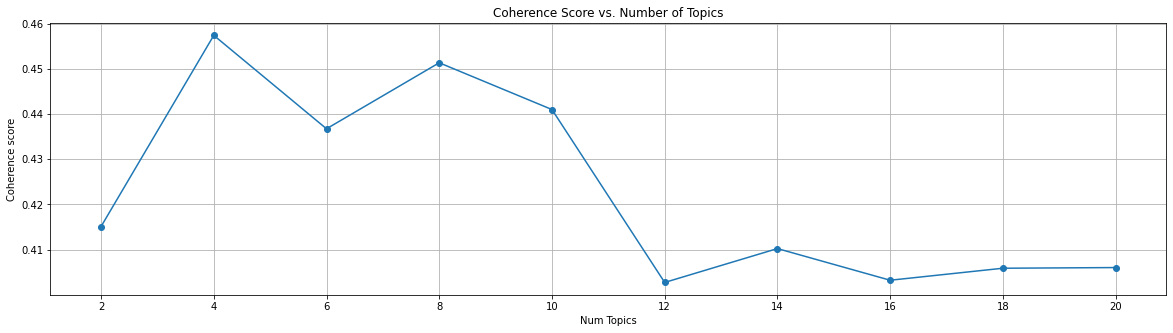

In [34]:
start=2; limit=22;  step=2;
x = range(start, limit, step)

plt.figure(figsize=(20,5))
plt.grid()
plt.title("Coherence Score vs. Number of Topics")
plt.xticks(x)
plt.plot(x, coherence_values, "-o")

plt.xlabel("Num Topics")
plt.ylabel("Coherence score")

plt.show();

In [37]:
# use np.argmax() to get index of largest coherence value from coherence_values - save result to `max_cohereance_val_index`
max_cohereance_val_index = np.argmax(coherence_values)
# use `max_cohereance_val_index` to index model_list for the corresponding model - save result to `lda_trained_model`
lda_trained_model = model_list[max_cohereance_val_index]

# YOUR CODE HERE
print(max_cohereance_val_index)
print(lda_trained_model)

1
LdaModel(num_terms=6676, num_topics=4, decay=0.5, chunksize=100)


## Use pyLDAvis to Visualize Your Topics 

Take a look at the topic bubbles and bar chart for the terms on the right-hand side.  

- Describe the topic bubbles. 
- Do they overlap or not? 
- What does it mean when they overlap? 
- What does it mean when they don't overlap?
- Are the terms in each topic distinct from the topics in the other topic bubbles?


In [38]:
pyLDAvis.enable_notebook()

In [40]:
# plot your topics here
# YOUR CODE HERE
vis = pyLDAvis.gensim.prepare(lda_trained_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.147195 -0.034458       1        1  32.098634
1      0.092556 -0.003354       2        1  27.437477
0     -0.153940 -0.126629       3        1  22.330871
2     -0.085811  0.164441       4        1  18.133018, topic_info=        Term         Freq        Total Category  logprob  loglift
5       love  4170.000000  4170.000000  Default  30.0000  30.0000
1333     kid  1874.000000  1874.000000  Default  29.0000  29.0000
688   tablet  6247.000000  6247.000000  Default  28.0000  28.0000
1      great  4492.000000  4492.000000  Default  27.0000  27.0000
105    price  1927.000000  1927.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
425     book   246.817958  1402.768777   Topic4  -4.9241  -0.0301
272      buy   312.483888  3277.820887   Topic4  -4.6882  -0.6429
312     need   205.376088  1017.902191   Topic4  -5.1079   0.1068
1      great   197.958035  4492.897679   Topic4  -5.1447  -1.4148
49      want   167.370716   964.193130   Topic4  -5.3125  -0.0436

[314 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1122      1  0.892149  absolutely
1122      3  0.092291  absolutely
1122      4  0.015382  absolutely
1518      1  0.117352     account
1518      2  0.008693     account
...     ...       ...         ...
1786      2  0.955887        xmas
1014      1  0.981143        year
1014      3  0.002714        year
1014      4  0.015606        year
1342      1  0.994160       young

[583 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 3])

## Create a Topic ID/Name Dictionary 

When populating your topic id/name dictionary, use the index order shown in the viz tool. 

We'll use a function to map the viz tool index ordering, with the train LDA model ordering. 

In [41]:
# create a dictionary 
# keys - use topic ids from pyLDAvis visualization 
# values - topic names that you create 
# save dictionary to `vis_topic_name_dict`

# YOUR CODE HERE
vis_topic_name_dict = {
    1:'gift_recommendation',
    2:'positive_reviews',
    3:'negative_reviews',
    4:'apps'
}

In [42]:
def get_topic_id_lookup_dict(vis, vis_topic_name_dict):
    """
    The starting index and the ordering of topic ids between the trained LDA model and the viz tool are different. So we need to create a look up dictionary that maps 
    the correct association between topic ids from both sources. 
    """
    # value is order of topic ids according to pyLDAvis tool 
    # key is order of topic ids according to lda model
    model_vis_tool_topic_id_lookup = vis.topic_coordinates.topics.to_dict()

    # invert dictionary so that 
    # key is order of topic ids according to pyLDAvis tool 
    # value is order of topic ids according to lda model
    topic_id_lookup =  {v:k for k, v in model_vis_tool_topic_id_lookup.items()}
    
    return {v:vis_topic_name_dict[k]  for k, v in topic_id_lookup.items()}

In [43]:
# YOUR CODE HERE
topic_name_dict = get_topic_id_lookup_dict(vis, vis_topic_name_dict)

## Assign Each Document a Topic Name

Now that we have a topic id/name look-up dict aligned with the index ordering of the trained LDA model, we can give each topic a topic name. 

The function below has been given to you. However, you are highly encouraged to read through it and make sure that you understand what it is doing each step of the way. A good way to do this is to copy and paste the code inside the function into a new cell, comment out all the lines of code and line by line, uncomment the code and see the output. 

In [44]:
def get_topic_ids_for_docs(lda_model, corpus):
    
    """
    Passes a Bag-of-Words vector into a trained LDA model to get the topic id of that document. 
    
    Parameters
    ----------
    lda_model: Gensim object
        Must be a trained model 
        
    corpus: nested lists of tuples, 
        i.e. [[(),(), ..., ()], [(),(), ..., ()], ..., [(),(), ..., ()]]
        
    Returns
    -------
    topic_id_list: list
        Contains topic ids for all document vectors in corpus 
    """
    
    # store topic ids for each document
    doc_topic_ids = []

    # iterature through the bow vectors for each doc
    for doc_bow in corpus:
        
        # store the topic ids for the doc
        topic_ids = []
        # store the topic probabilities for the doc
        topic_probs = []

        # list of tuples
        # each tuple has a topic id and the prob that the doc belongs to that topic 
        topic_id_prob_tuples = lda_trained_model.get_document_topics(doc_bow)
        
        # iterate through the topic id/prob pairs 
        for topic_id_prob in topic_id_prob_tuples:
            
            # index for topic id
            topic_id = topic_id_prob[0]
            # index for prob that doc belongs that the corresponding topic
            topic_prob = topic_id_prob[1]

            # store all topic ids for doc
            topic_ids.append(topic_id)
            # store all topic probs for doc
            topic_probs.append(topic_prob)

        # get index for largest prob score
        max_topic_prob_ind = np.argmax(topic_probs)
        # get corresponding topic id
        max_prob_topic_id = topic_ids[max_topic_prob_ind]
        # store topic id that had the highest prob for doc being a memebr of that topic
        doc_topic_ids.append(max_prob_topic_id)
        
    return doc_topic_ids

In [45]:

# use get_topic_ids_for_docs get the topic id for each doc in the corpus - save result to `doc_topic_ids`

# create a new feature in df_electronics called topic_id using `doc_topic_ids`

# iterate through topic_id and use the lookup dict `topic_name_dict` to assign each document a topic name
# save results to a new feature in df_electronics called `new_topic_name`

# YOUR CODE HERE
doc_topic_ids = get_topic_ids_for_docs(lda_trained_model, corpus)
df_electronics['topic_ids'] = doc_topic_ids
df_electronics['new_topic_name'] = df_electronics['topic_ids'].apply(
    lambda topic_id : topic_name_dict[topic_id]
)

## Congratulations! You have created new topic names for your documents. 

In [46]:
cols = ["reviews.text", "new_topic_name"]
df_electronics[cols].head()

,reviews.text,new_topic_name
8343,Great case to keep everything in its place! My...,gift_recommendation
8344,After discarding and getting rid of broken cd ...,negative_reviews
8345,"A few dollars more, but I am boycotting amazon",apps
8346,My initial impression of this was very good. T...,negative_reviews
8347,Pros: Standard Echo. Cons: Older generation Ec...,negative_reviews


In [52]:
df_electronics['reviews.text'][8346]

"My initial impression of this was very good. The material is nicer than the shiny stuff on my Hama CD binders and the netting trim gives a nice appearance compared to plain look of most budget CD binders.There are 50 pages with 8 disc pockets each (4 per side) giving a total of 400 capacity. The pages are hung from the spine in two groups of 25. By that I mean that 25 pages all have a single attachment point to the plastic spine.This is where the first problem with this binder lies. Because each group of 25 pages shares the same anchor point in the spine, the pages cannot sit flat once full of discs. They bend and arch, and apart from looking tatty this puts a lot of tension across the plastic film. With long-term usage I suspect this plastic film will will tear due to the tension. It also makes it awkward to browse the binder as the pages don't sit flat. It may even crack or bend your discs.I look to my Hama 120 binder to see how it *should* be done - it only has 30 pages and yet the

-----
# Stretch Goals

- Treat `new_topic_name` as a Y vector and train a supervised learning model to predict the topic of each document.